<a href="https://colab.research.google.com/github/Clement-Moreau-Info/Enseignements/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel BRED Datascience -- Clustering

Clément Moreau

----


Ce tutoriel est dédié à la manipulation et à l'analyse des principaux algorithmes et techniques d'apprentissage non supervisée (i.e., clustering). 

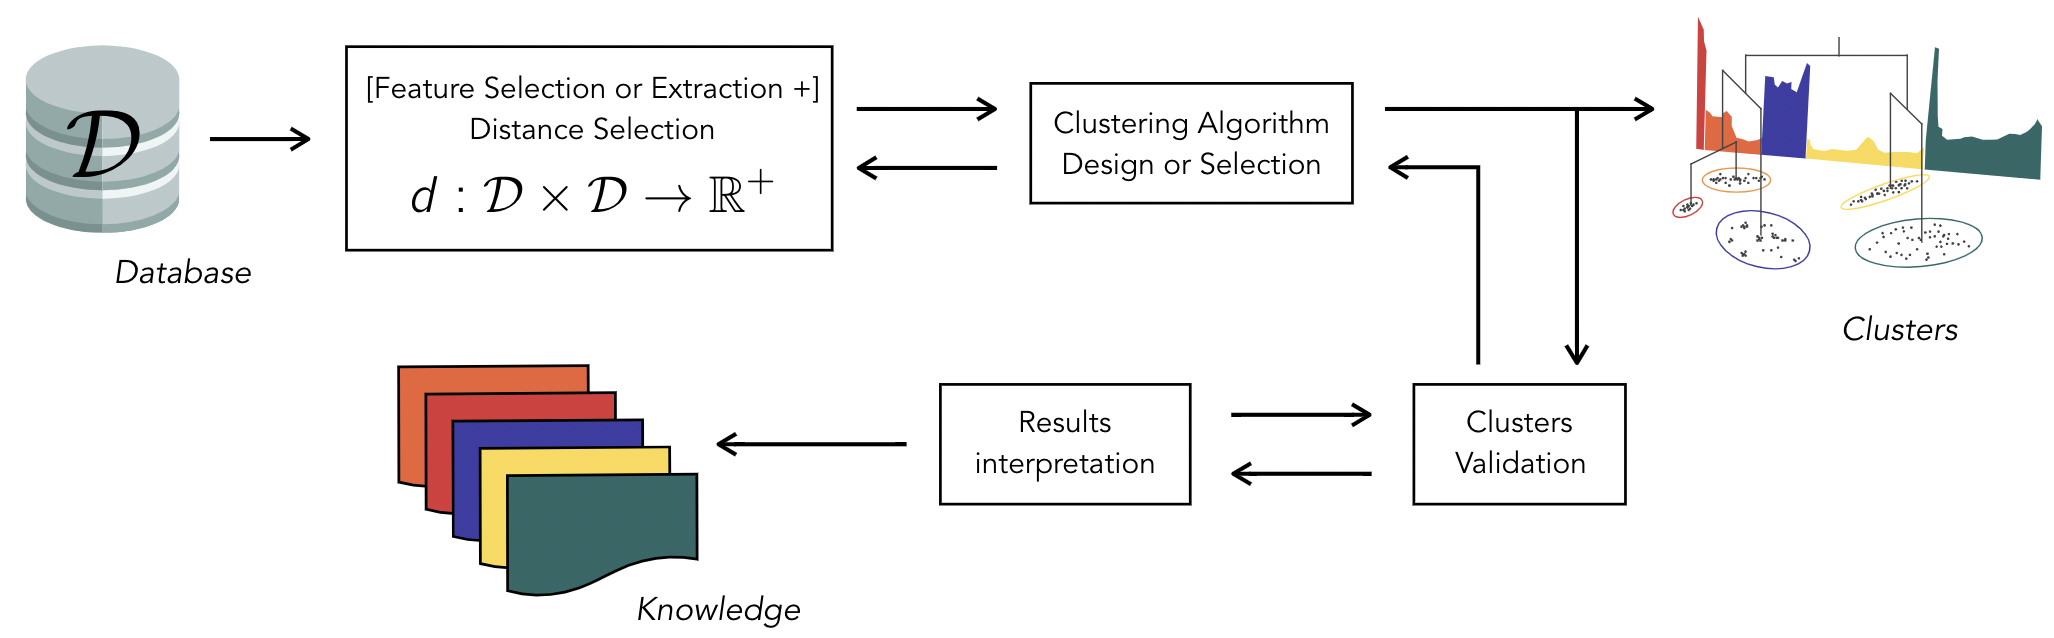

Comme illustré sur la figure ci-dessus tirée de l'article [Survey of clustering algorithms](https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=1763&context=ele_comeng_facwork) (Xu et Wush, 2005), le processus de clustering se déroule en **4 grandes étapes** : 

1. La sélection de la distance
2. La sélection de l'algorithme de clustering
3. La validation des clusters à l'aide d'une mesure de qualité
4. L'interprétation des clusters

Dans ce tutoriel, nous aborderons les étapes 1 à 3. 

Sauf indication contraire, nous manipulerons des jeux de données numériques telles que $\mathcal{D} \subset \mathbb{R}^n$ et utiliserons la distance euclidienne comme distance par défaut telle que : 

$$||x-y|| = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$$

avec $x,y \in \mathbb{R}^n$, deux vecteurs numériques de dimensions $n$. 

## Importation des librairies

In [268]:
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Couleurs pour les clusters
colors = sns.color_palette("tab10")
colors = np.hstack([matplotlib.colors.rgb2hex(x) for x in colors]+['black'])

## K-means clustering

On considère notre ensemble de données $\mathcal{D}$ (avec $|\mathcal{D}| = n$) l'ensemble des points du plan suivants : 

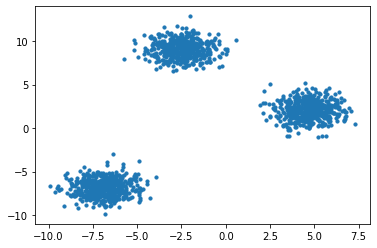

In [269]:
# Nombre de données |D| = n = 1500
n_samples = 1500

blobs = datasets.make_blobs(n_samples=n_samples, random_state=42)
X, y = blobs
plt.scatter(X[:, 0], X[:, 1],  s=10)

<font color='blue'>
<i>
<b>
1. Visuellement, combien de clusters  identifiez-vous ?
</b>
</i>
</font>

> Afin de regrouper nos différents ensemble de points, nous proposons de mettre en place un premier algorithme, [K-means](https://en.wikipedia.org/wiki/K-means_clustering). 
>
> Pour rappel, le principe de K-means consiste à initialiser $k$ centres de gravité $\mu_{i\in[\![1,k]\!]}$, de manière aléatoire et assigner au cluster $C_i$, à chaque itération, tous les objets $x \in \mathcal{D}$ tel que $\mu_i$ est le plus proche. 
>
> Les $\mu_i$ sont ensuite affinés en recalculant leurs coordonnées pour les $x\in C_i$. Ainsi, l’objectif de K-means est de minimiser la fonction :
> 
> $$\sum_{i=1}^K \sum_{x\in C_i} ||x-\mu_i||^2$$
>
> La convergence de l’algorithme est assurée car le centre de gravité est l’objet qui minimise l’inertie intra-cluster. Par le théorème de Huygens, cela revient aussi à maximiser l’inertie inter-classe.

------

**Point technique** 

- L'algorithme K-means est incapable de traiter des clusters de formes concaves.
- La complexité de K-means est en $O(n \times k \times iter)$ (où $iter$ est le nombre d'itérations de l'algorithme).

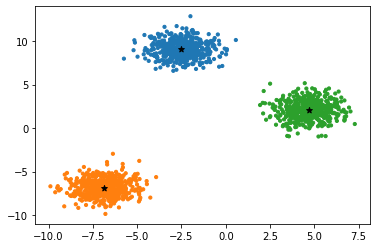

In [272]:
from sklearn.cluster import KMeans

# Nombre de clusters K à rentrer 
K = 3

algorithm = KMeans(n_clusters=K) 
f = algorithm.fit(X)
y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, c = colors[y_pred.astype(int)])
# Ajout des centres de gravité
plt.scatter(x=f.cluster_centers_[:,0], y=f.cluster_centers_[:,1], color='black', marker='*')

Nous constatons très simplement ici que la qualité de notre clustering est excellente. Toutefois, lorsqu'il est impossible de visualiser les clusters comme en apprentissage en haute dimension, une mesure de qualité de clustering peut-être requise afin de sélectionner le nombre de clusters adéquat. 

Parmi elles, l'indice [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering) est une mesure comprise dans $[-1,1]$ permettant de juger à la fois la cohésion d'un cluster (points densément regroupés) et la séparation (clusters éloignés les uns des autres). 

Plus le score tend vers 1, plus la qualité du clustering est jugée optimale. 


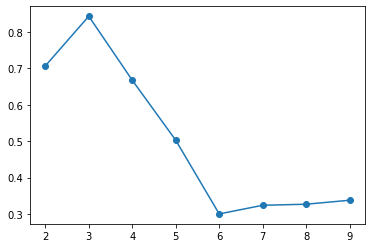

In [255]:
from sklearn.metrics import silhouette_score

sil = []
for k in range(2,10):
    algorithm = KMeans(n_clusters=k) 
    algorithm.fit(X)
    y_pred = algorithm.predict(X)
    sil.append(silhouette_score(X, y_pred))

plt.plot(range(2,10), sil, 'o-')

<font color='blue'>
<i>
<b>
2. Quel est le score de Silhouette pour le meilleur nombre de clusters déterminé question 1.
</b>
</i>
</font>

## Clustering à densité

### DBSCAN

On considère désormais le jeu de données suivant : 

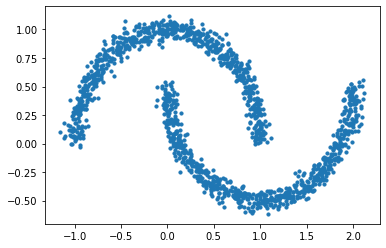

In [274]:
moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = moons
plt.scatter(X[:, 0], X[:, 1],  s=10)

<font color='blue'>
<i>
<b>
3. Appliquer l'algorithme K-means avec $k=2$. Qu'observez-vous ? Expliquez pourquoi l'algorithme échoue à reconstituer les clusters sur cet exemple.
</b>
</i>
</font> 

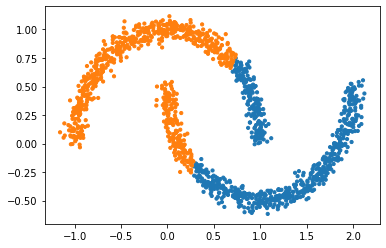

In [275]:
algorithm = KMeans(n_clusters=2) 
f = algorithm.fit(X)
y_pred = algorithm.predict(X)

plt.scatter(X[:, 0], X[:, 1], s=10, c = colors[y_pred.astype(int)])

Nous introduisons à partir d'ici une nouvelle famille d'algorithmes de clustering appelée _Algorithmes à densité_. 

Parmi eux, l'algorithme [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) proposé par Ester et al. dans [A Density-Based Algorithm for Discovering Clusters
in Large Spatial Databases with Noise](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf?source=post_page),  utilise deux paramètres : un rayon $\varepsilon$ et un nombre minimum de points $minPts$. 

L’idée de l’algorithme est, pour une donnée $x \in \mathcal{D}$, de  déterminer son $\varepsilon$-voisinage $V_{\varepsilon}(x)$ tel que :

$$V_{\varepsilon}(x)=\{y|y\in \mathcal{D}, d(x,y) < \varepsilon\}$$

Mathématiquement, le voisinage correspond à la boule de rayon $\varepsilon$ autour de l’objet $x$. On dit alors que le voisinage de $x$ est dense si :

$$|V_{\varepsilon}(x)| \geq minPts$$


Ainsi, pour un objet $x$ donné dont le voisinage est dense, on calcule ensuite le voisinage $V_{\varepsilon}(y)$ pour tout $y\in V_{\varepsilon}(x)$. On continue récursivement et de proche en proche pour tout voisinage dense jusqu'à trouver l’ensemble des objets du cluster.


**Point technique**

- L'algorithme DBSCAN produit des "effets de chainage" des données, pas toujours désirés. 
- Les paramètres $\varepsilon$ et $minPts$ ne sont pas toujours simples à trouver. 
- La complexité de DBSCAN est de l'ordre de $O(n\log(n))$. 


<font color='blue'>
<i>
<b>
4. Quelles techniques proposez-vous afin d'estimer les paramètres $minPts$ et $\varepsilon$ ?
</b>
</i>
</font>

_Réponse ici ..._

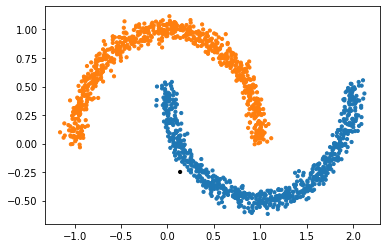

In [278]:
algorithm = cluster.DBSCAN(eps= ..., min_samples = ...)
f = algorithm.fit(X)
if hasattr(algorithm, 'labels_'):
  y_pred = algorithm.labels_.astype(int)
else:
  y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, c = colors[y_pred.astype(int)])

<font color='blue'>
<i>
<b>
5. Sous hypothèse d'être en dimension $d$ et pour des valeurs $\varepsilon$ et $minPts$ données, par quelle valeur est-il approprié de changer $minPts$ si l'on double la valeur de $\varepsilon$ ?
</b>
</i>
</font>

On considère désormais le jeu de données suivant : 

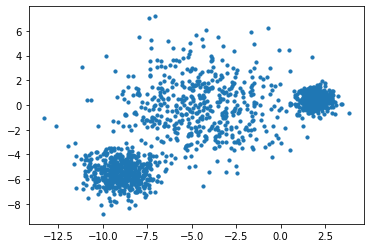

In [279]:
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1, 2.5, 0.5],
                             random_state=170) 
X, y = varied
plt.scatter(X[:, 0], X[:, 1],  s=10)

<font color='blue'>
<i>
<b>
6. Testez les algorithmes précédents avec les paramètres adéquats. Que remarquez-vous ? Quel est le score Silhouette de $k$-means pour $k=3$ ?
</b>
</i>
</font>


In [260]:
# Code à insérer ici...

<font color='blue'>
<i>
<b>
7. Pourquoi DBSCAN échoue t-il à regrouper correctement les points ?
</b>
</i>
</font>

### Optics

L'algorithme [OPTICS](https://en.wikipedia.org/wiki/OPTICS_algorithm) fournit une alternative à DBSCAN. En substance, OPTICS est un algorithme également basé sur la densité mais capable de gérer les variations de densité au sein des différents clusters à découvrir. 
 
Ainsi, l'avantage d'OPTICS est qu'il en capacité à découvrir des clusters sans avoir besoin de renseigner la variable $\varepsilon$. 
 
Les deux variables couramment utilisées pour son initialisation sont $minPts$ et $minCusterSize$.  
 
<font color='blue'>
<i>
<b>
8. Testez OPTICS avec les paramètres `min_samples = 4` et `min_cluster_size = .2`. 
</b>
</i>
</font>

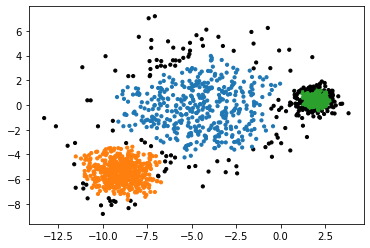

In [280]:
algorithm = cluster.OPTICS(min_samples = 4, min_cluster_size= .2)

f = algorithm.fit(X)
if hasattr(algorithm, 'labels_'):
  y_pred = algorithm.labels_.astype(int)
else:
  y_pred = algorithm.predict(X)

# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, c = colors[y_pred.astype(int)])

## Clustering spectral
 
Popularisé par Ng et al. dans [On spectral clustering : Analysis and an algorithm](https://proceedings.neurips.cc/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf), le principe du clustering spectral est de transformer les données $x_i \in \mathcal{D}$ dans un nouvel espace de points $y_i \in \mathbb{R}^p$ via un graphe de similarité, sa matrice laplacienne associée et les $p$ premiers vecteurs propres de cette matrice. 
 
En outre, les propriétés des matrices laplaciennes font que ce nouvel ensemble de points $y_i$ est facilement classifiable en $p$ groupes.
 
L’intuition du clustering spectral repose sur une bonne interprétation algébrique du spectre du Laplacien. Celui-ci est particulièrement étudié en physique statistique pour analyser la diffusion sur un graphe d’origine, par exemple la chaleur. Ici, métaphoriquement, plus des données sont similaires, plus l’information se diffuse facilementau sein des zones denses du graphe. Enfin, l’analyse du spectre revient à l’extraction des $p$ premiers vecteurs propres ce qui est très similaire à une analyse par ACP (Analyse en Composante Principale). Dans ce nouvel espace, les individus initiaux (noeuds du graphe) sont mieux séparés et c’est pourquoi un algorithme de clustering tel que $k$-means donne de bons résultats.
 
**Point technique**
 
- La complexité de Spectral est de l'ordre de $O(n^3)$. 
- Les paramètres classiques de Spectral sont `n_cluster` (nombre de clusters), `eigen_solver` (le solveur de valeurs propres pour le laplacien) et `affinity` (gestion de la connexité du graphe de similarité). 



<font color='blue'>
<i>
<b>
9. Tester l'algorithme Spectral pour les jeux de données précédents (blobs, moons et varied). Que constatez-vous ? 
</b>
</i>
</font>

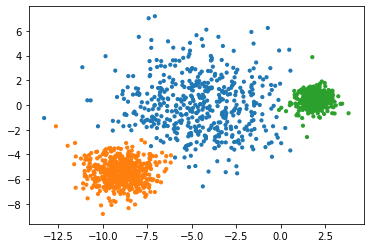

In [281]:
algorithm = cluster.SpectralClustering(
            n_clusters=3, 
            eigen_solver='arpack',
            affinity="nearest_neighbors")
 
f = algorithm.fit(X)
if hasattr(algorithm, 'labels_'):
  y_pred = algorithm.labels_.astype(int)
else:
  y_pred = algorithm.predict(X)
 
# Affichage des clusters
plt.scatter(X[:, 0], X[:, 1], s=10, c = colors[y_pred.astype(int)])

## Réduction de dimensionnalité


Dans la suite de cette partie, nous allons utiliser le jeu de données [MNIST](http://yann.lecun.com/exdb/mnist/) rendu célèbres par les études faites par Yann LeCun et al. sur celui-ci.

 

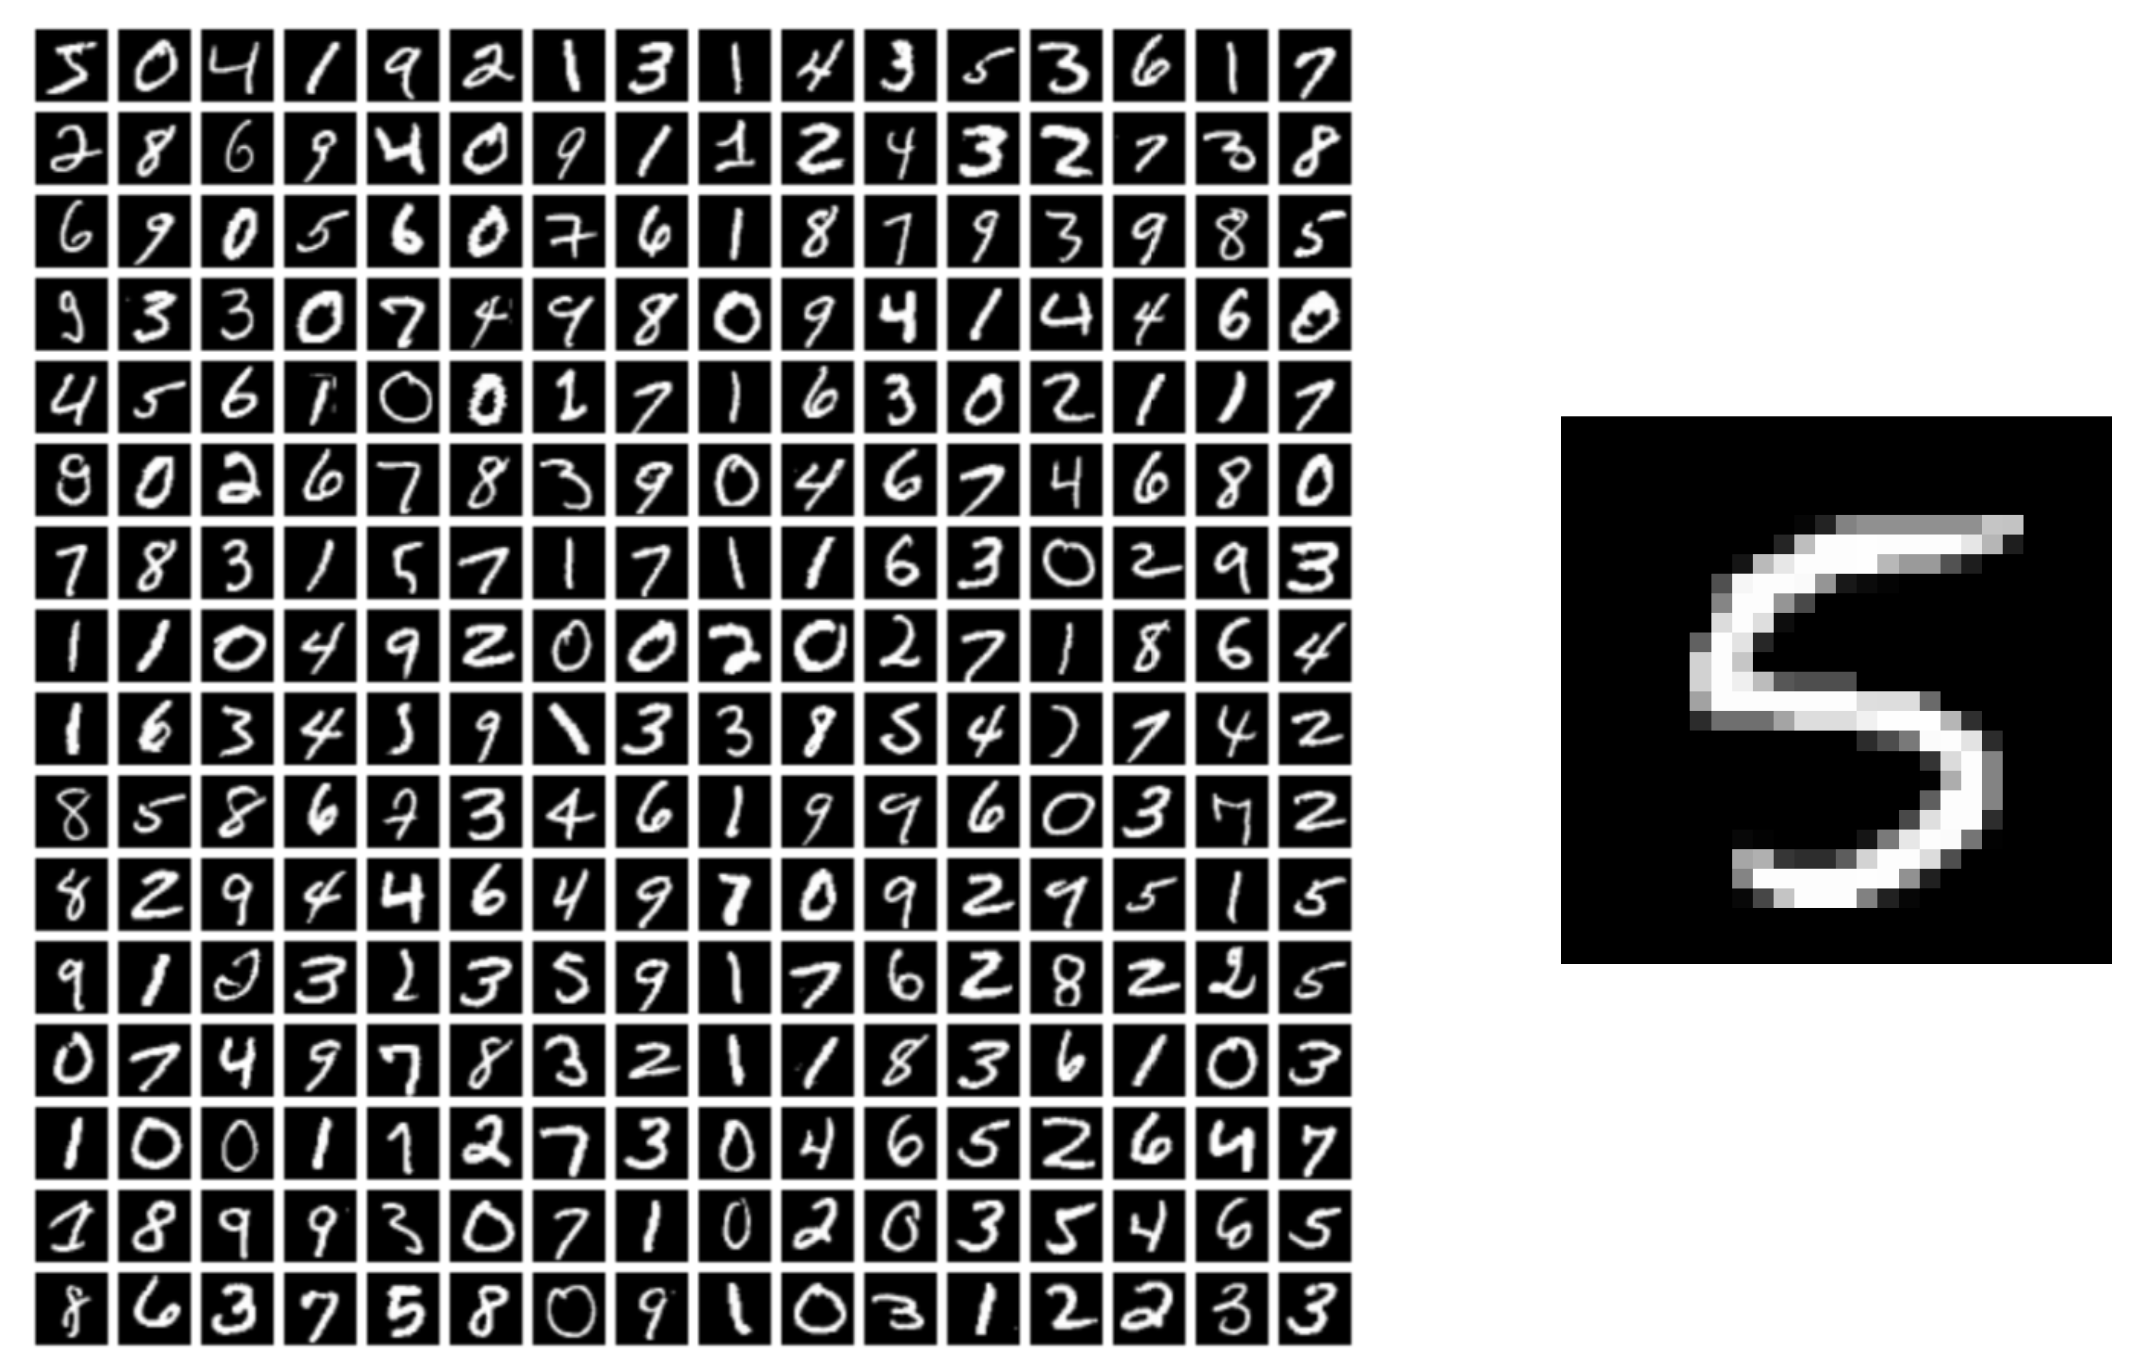

Le jeu MNIST est constitué initialement de 70.000 images de chiffres manuscrits au format 28 pixels par 28 pixels où chaque pixel est représenté par un niveau de gris allant de 0 à 255. Un chiffre manuscrit est vu comme un vecteur de $\{0, ..., 255\}^{28\times28}$ .

In [282]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist.data.shape

perc_train = .8

train_X = np.array(mnist.data.iloc[:int(mnist.data.shape[0]*perc_train),])
train_y = np.int_(mnist.target.iloc[:int(mnist.data.shape[0]*perc_train),])
test_X = np.array(mnist.data.iloc[int(mnist.data.shape[0]*perc_train):,])
test_y = np.int_(mnist.target.iloc[int(mnist.data.shape[0]*perc_train):,])

<font color='blue'>
<i>
<b>
10. Vérifiez que le jeu MNIST est équilibré. 
</b>
</i>
</font>

In [283]:
# Code à insérer ici...

On propose d'utiliser l'algorithme $k$-NN afin de prédire la classe des images du jeu de test. 

Pour rappel, l'algorithme $k$-NN (ou $k$-Nearest Neighbours, ou algorithme des $k$ plus proches voisins) peut être formalisé comme suit : 

```
Result: kNN(X, Y, x, k)
Input : 
  X, l’ensemble d’apprentissage,
  Y, classe des données de X,
  x, une nouvelle donnée à classifier, 
  k, nombre de voisins considérés
Output: 
  Classe prédite pour x
----
FOR i ∈ [1, |X|]
  Calcul de la distance euclidienne ||Xi − x||^2
END
Calcul de l’ensemble I contenant les indices des k plus petites distances ||Xi − x||^2.
RETURN Classe majoritaire pour {Yi |i ∈ I }
----
```

<font color='blue'>
<i>
<b>
11. En considérant les données d'apprentissage $X_i \in \mathcal{X}$ comme étant de dimension $p$ (i.e., $X_i \in \mathbb{R}^p$), rappelez la complexité de l'algorithme $k$-NN. 
</b>
</i>
</font>

<br>
<br>

<font color='blue'>
<i>
<b>
12. Appliquez l'algorithme $k$-NN sur le jeu de données MNIST, on fixera $k=5$ et notez le temps d'exécution nécessaire. 
</b>
</i>
</font>

In [287]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(5)
KNN.fit(train_X, train_y)

print("Accuracy", KNN.score(train_X, train_y))

KNeighborsClassifier()

<font color='blue'>
<i>
<b>
12. Quelle est l'accuracy de notre modèle ? Quel est finalement le principal défaut de $k$-NN ? 
</b>
</i>
</font>

### Premier modèle de réduction : Analyse en Composante Principale

L’analyse en composantes principales (ACP) est une technique de réduction de dimensionnalité d'un espace $E$ de grande dimension dans un sous-espace $H$ de dimension faible (typiquement égale à 2 ou 3), et dans lequel on aura la meilleure représentation de notre ensemble de données. 


L’ACP vise alors à trouver le sous-espace sur lequel le projeté des données $\mathcal{D}$ aura la plus grande **_dispersion_**. Aussi, le principe de l’ACP est de chercher de nouvelles variables, appelées _composantes principales_, par combinaison linéaire des variables initiales et telles que ces nouvelles variables aient la plus grande variance possible. Cette variance est représentée par la valeur propre de l’axe. 




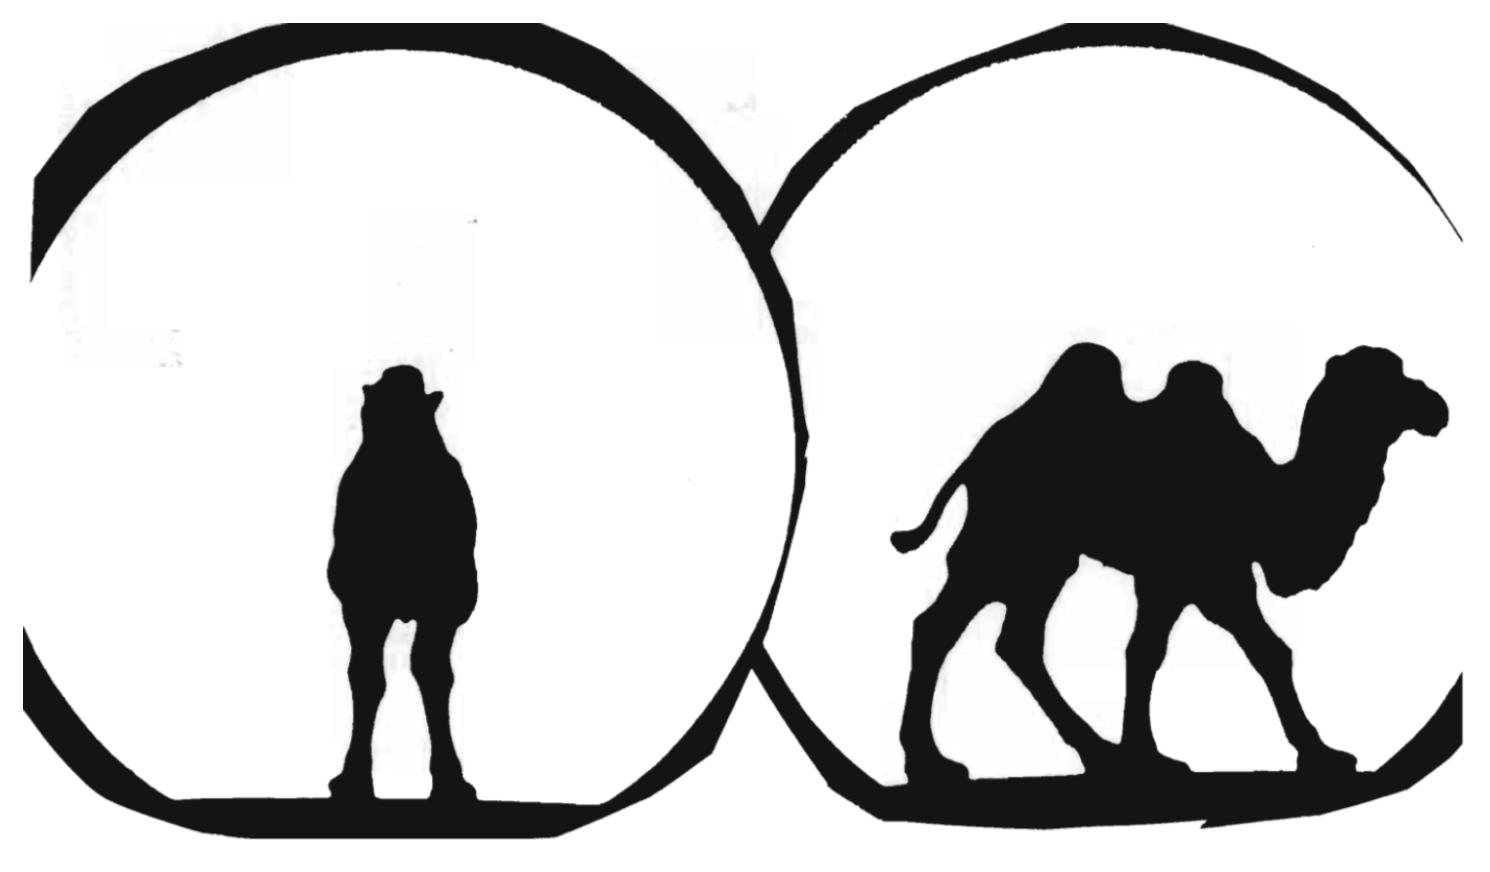

_Quel axe de projection à la plus grande variance ?_

Nous allons essayé de projeter nos images MNIST (jeu test `train_X`) dans un plan en 2 dimensions à l'aide d'une analyse en composantes principales. 

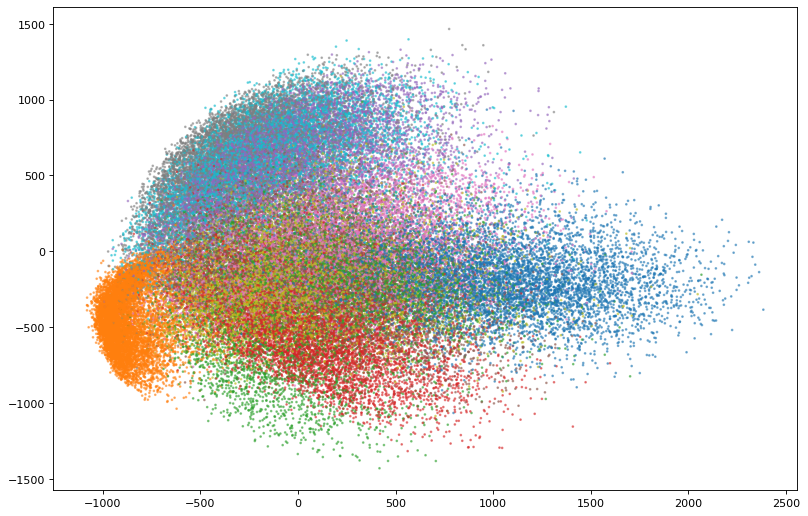

In [291]:
from sklearn.decomposition import PCA

# Affichage de la palette
sns.color_palette("Spectral", n_colors=10)

# Projection à 95% de variance expliquée
pca = PCA(.95) 
mnist_pca = pca.fit_transform(mnist.data)

plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(mnist_pca[:,0], mnist_pca[:,1],  c = colors[mnist.target.astype(int)], s=2, alpha=0.5)

<font color='blue'>
<i>
<b>
13. Visuellement, quelle est la qualité de la projection ? 
</b>
</i>
</font>

<br>
<br>


Soit ($\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_d)$, le spectre de la matrice des données $X. X^t$ (i.e., l'ensemble des valeurs propres). 

L'inertie de l'axe factoriel $i$ (grosso modo, sa part d'explication aux données) est exprimé par le taux d'inertie $\tau_i$ tel que :

$$\tau_i = \frac{\lambda_i}{\sum_k^n\lambda_k}$$

La commande `pca.explained_variance_ratio_` permet d'obtenir la liste des taux d'inertie jusqu'au nombre de dimensions données pour `pca` et la commande `pca.n_components_` le nombre d'axes retenus.

<font color='blue'>
<i>
<b>
14. Combien de dimensions sont nécessaires afin d'expliquer 95% de la variance du jeu de données ? Quel pourcentage explique du jeu de données explique l'axe factoriel n°1 ? 
</b>
</i>
</font>



In [286]:
# Code à insérer ici...

Il Il est possible d'avoir une reconstitution de l'image en fonction de la projection de l'ACP grâce à la commande `pca.inverse_transform` .

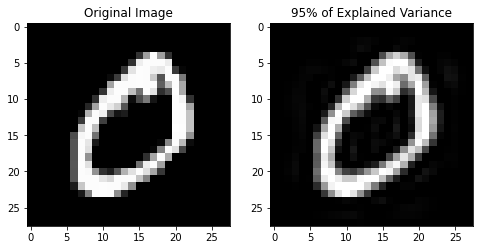

In [116]:
plt.figure(figsize=(8,4));

# Reconstitution de l'image
approx = pca.inverse_transform(mnist_pca)

# Image origine
plt.subplot(1, 2, 1);
plt.imshow(np.array(mnist.data.iloc[1,]).reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('Original Image');

# Image reconstruite
plt.subplot(1, 2, 2);
plt.imshow(approx[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('95% of Explained Variance');

<font color='blue'>
<i>
<b>
15. Affichez la projection de l'image pour une variance totale expliquée de 5%. 
</b>
</i>
</font>

In [292]:
# Code à insérer ici...

Nous allons désormais appliquer à nouveau $k$-NN sur la projection ACP de MNIST. 

<font color='blue'>
<i>
<b>
16. Lancez l'algorithme sur la projection ACP de MNIST et notez le temps d'exécution. Quelle est la baisse de performance de l'algorithme selon la mesure d'accuracy ? 
</b>
</i>
</font>

In [294]:
approx_train_X = np.array(mnist_pca[:int(len(mnist_pca)*perc_train),])
approx_test_X = np.array(mnist.data.iloc[int(len(mnist_pca)*perc_train):,])

KNN = KNeighborsClassifier(5)
KNN.fit(approx_train_X, train_y)
#print("Accuracy", KNN.score(approx_train_X, train_y))

KNeighborsClassifier()

## Uniform Manifold Approximation and Projection (UMAP)

L'algorithme [UMAP]() de Mc Innes et al. est une nouvelle technique de réduction de dimensionnalité non linéaire capable de traiter rapidement et efficacement les données en très haite dimensions. UMAP est plus rapide que l'algorithme [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (ancien algorithme de référence) dont il s'inspire avec [LLE](https://www.science.org/doi/full/10.1126/science.290.5500.2323?casa_token=8PC8wUPYrk4AAAAA:yMgzkafAemazS-K1DUtw_cN_UptLROZBrO2pIemsRwbTq1HxQaX_pu56fzDL4HFbAfBI2iQ21Hmy).


Sans détailler les outils mathématiques utilisés par cette technique, UMAP est inspirée des techniques de réduction non-linéaire qui cherchent à conserver les relations topologiques locales en priorité. Au final les dimensions ne sont pas des combinaisons linéaires des distances de départ, comme cela serait le cas pour une ACP classique, mais une reproduction de la distribution normale des distances dans l’espace de départ par une distribution de Student à l’arrivée. 

UMAP réclame peu d’hyperparamètres : `n_neighbors` un nombre de voisins à prendre en compte dans la reproduction de la distribution des distances et `min_dist` qui permet de contrôler la rigueur avec laquelle UMAP est autorisé à regrouper les points dans l’espace d’arrivée.

In [158]:
# Installation de UMAP

!pip install umap-learn[plot] -q
!pip install tbb
import umap

     |████████████████████████████████| 86 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 10.1 MB/s 
     |████████████████████████████████| 15.8 MB 1.6 kB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 133 kB 37.0 MB/s 
     |████████████████████████████████| 830 kB 37.7 MB/s 
     |████████████████████████████████| 822 kB 41.6 MB/s 
     |████████████████████████████████| 802 kB 45.6 MB/s 
     |████████████████████████████████| 802 kB 41.4 MB/s 
     |████████████████████████████████| 793 kB 48.0 MB/s 
     |████████████████████████████████| 793 kB 15.2 MB/s 
     |████████████████████████████████| 791 kB 44.0 MB/s 
     |████████████████████████████████| 786 kB 45.2 MB/s 
     |████████████████████████████████| 779 kB 38.5 MB/s 
     |████████████████████████████████| 778 kB 48.3 MB/s 
     |████████████████████████████████| 776 kB 45.5 MB/s 
     |████████████████████████████████| 769 kB 28.3 MB/s 
     |████████████

<font color='blue'>
<i>
<b>
17. Testez l'algorithme UMAP sur le jeu de données MNIST avec un nombre de dimensions égale à 2. Qu'en pensez-vous ? 
</b>
</i>
</font>

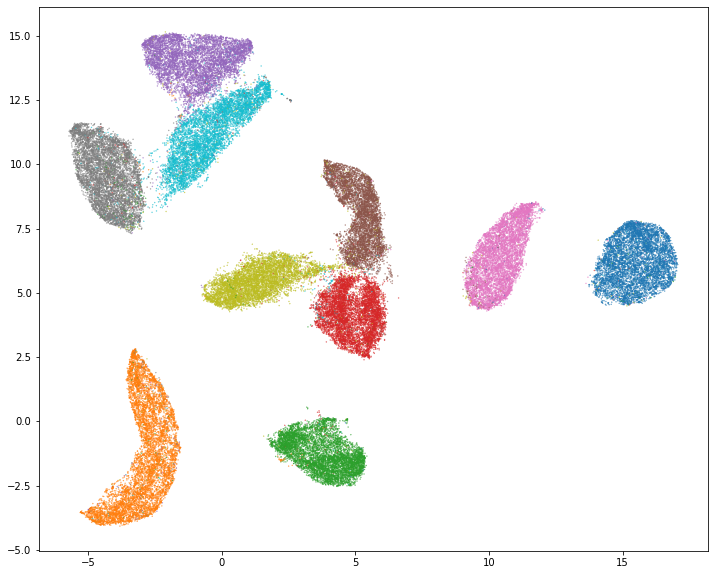

In [295]:
# Réduction 
reducer = umap.UMAP(random_state=42)

# Espace
embedding = reducer.fit_transform(mnist.data)

fig, ax = plt.subplots(figsize=(12, 10))

plt.scatter(embedding[:, 0], embedding[:, 1], c=colors[mnist.target.astype(int)],  s=0.1)
plt.show()

<font color='blue'>
<i>
<b>
18. Sous l'hypothèse que nous disposons d'aucune données étiquettées. Pouvez-vous imaginer un protocole afin de labéliser automatiquement les données MNIST à l'aide des précédentes techniques vues jusqu'à présent ? 
</b>
</i>
</font>

## Clustering sémantique

Terminons désormais par application plus originale du clustering, celle de regrouper des termes sémantiques (ou mot). 


Pour cela, nous allons utiliser l'ontologie (i.e. graphe de connaissances) lexical [Wordnet](https://wordnet.princeton.edu/) qui répertorie, classifie et hiérarchise des termes et contenus sémantiques. 


Grâce à cette base de connaissances, il est possible de comparer deux concepts comme les termes _chat_ et _chien_ par exemple à l'aide différentes mesures de similarité comme dans l'application demo proposée au [lien suivant](https://ws4jdemo.appspot.com/)

Parmi elle, la mesure de Wu-Palmer propose de tenir compte à la fois des concepts parents des termes comparée et de leurs spécificités. 


$$sim_{wup}(x,y)=\frac{2\times d(LCA(x,y))}{d(x)+d(y)}$$

Où $x,y$ sont les concepts comparés, $LCA$ désigne le concept commun le plus spécifique qui les rassemble (par exemple, le concept _mammifère_ pour chat et chien) et $d$, un nombre entier qui correspond à la profondeur des concepts depuis la racine ($root$) du graphe ; plus le concept est spécifique, plus cette valeur est élevée. 


<font color='blue'>
<i>
<b>
19. Donnez le co-domaine (i.e. l'intervalle des valeurs) que peut prendre $sim_{wup}$. Que vaut $sim_{wup}(x,x)$ ? Que vaut $sim_{wup}(root, x)$ ? 
</b>
</i>
</font>

Le code suivant permet de fournir la similarité selon la mesure de Wu-Palmer entre les concepts _chat_ et _chien_ :

In [299]:
import nltk
nltk.download('wordnet')

print(wordnet.synsets('cat')[0].wup_similarity(wordnet.synsets('dog')[0]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
0.8571428571428571


<font color='blue'>
<i>
<b>
20. Quelle est la similarité entre ces deux termes ? Cette valeur vous semble t-elle cohérente ? 
</b>
</i>
</font>


On considère l'ensemble des termes suivants : 

In [301]:
bag_words = ['dog', 'cat', 'wolf', 'lion', 'fish', 'dolphin', 'human', 'parrot', 
             'bird', 'chimpanzee', 'monkey', 'horse', 'cow', 'sheep']

# Calcul des paires de distance
dist = [1-wordnet.synsets(x)[0].wup_similarity(wordnet.synsets(y)[0]) for i, x in enumerate(bag_words) for j, y in enumerate(bag_words[i+1:])]

L'inconvénient majeur avec ce type de méthode est qu'_in fine_ on ne dipose pas d'un espace euclidien classique comme cela serait le cas pour des techniques des word embedding classiques. 

Toutefois, grâce à la mesure de Wu-Palmer, nous disposons d'une matrice de distance représentant la proximité sémantique entre nos différents concepts. Nous pouvons ainsi ré-utiliser des techniques de clustering afin de regrouper nos termes ensemble selon leur ressemblance estimée. 

Pour finir, nous allons introduire la technique de [classification ascendante hiérarchique](https://en.wikipedia.org/wiki/Hierarchical_clustering) (CAH). 


L'avantage de la CAH étant de disposer d'un rendu graphique, le dendrogramme, permettant d'apprécier la distance entre les données. 

**Point technique** 

- la CAH possède une complexité standard en $O(n^3)$. 
- Il existe plusieurs critère d'agrégation de la CAH parmi _Ward_, _Single_ et _Complete_. Ward possède des effets similaire à $k$-means et minimise la fonction objective. 

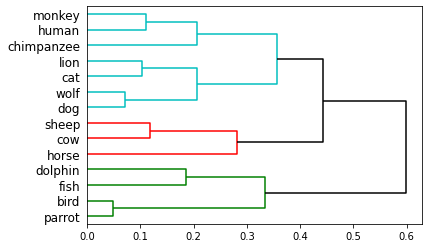

In [241]:
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linkage_matrix = linkage(dist, "ward") # ward, single, complete
dendo = dendrogram(linkage_matrix, orientation='right',
                   labels=bag_words, above_threshold_color='black')

plt.show()

<font color='blue'>
<i>
<b>
21. Que pensez-vous des clusters obtenus ? Quels écueils trouvez-vous à cette méthode (mesure + clustering) ? 
</b>
</i>
</font>

Enfin, on peut également chercher à projeter nos individus en 2D grâce à UMAP comme nous l'avons fait précédemment pour les images MNIST. 

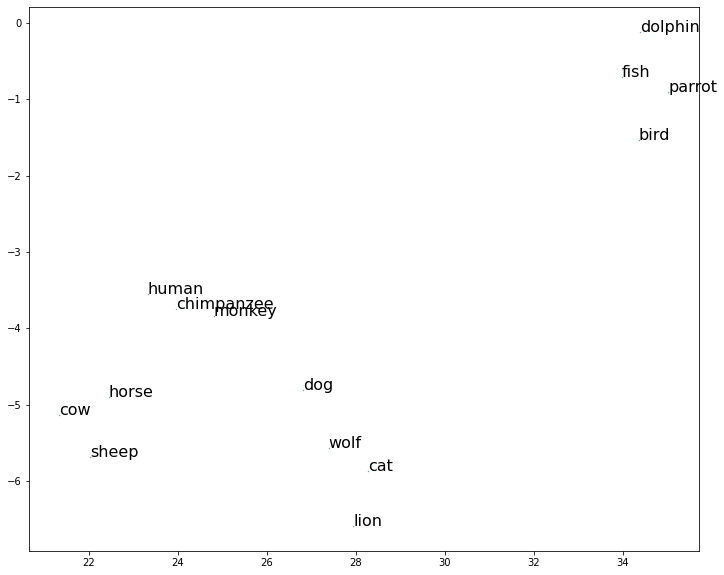

In [304]:
sem_data = squareform(np.array(dist))


reducer = umap.UMAP(n_components=2, n_neighbors=3, min_dist=.5, random_state=42)
embedding = reducer.fit_transform(sem_data)

fig, ax = plt.subplots(figsize=(12, 10))
color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1)

for i, txt in enumerate(bag_words):
    ax.annotate(txt, (embedding[i, 0], embedding[i, 1]), fontsize=16)